# **메인퀘스트 진행을 위한 Key Infomation**
1. 정확한 언급을 위하여 각 코드 블럭 상단에 주석으로 넘버링을 하였음. (예: # 1)
2. 원래 전체 코드 블럭은 #1 ~ # 38 까지 구성되었음.
3. 메인 퀘스트로 추가된 블럭은..


# 퀘스트 1. Transformer와 비교해 변경이 필요한 부분을 서술


인터더-디코더 구조의 트랜스포머에서 디코더 뿐인 GPT로 변활 할 때, 다음의 코드 블럭에서 적시된 수정방향으로 코딩이 변경되어야 함




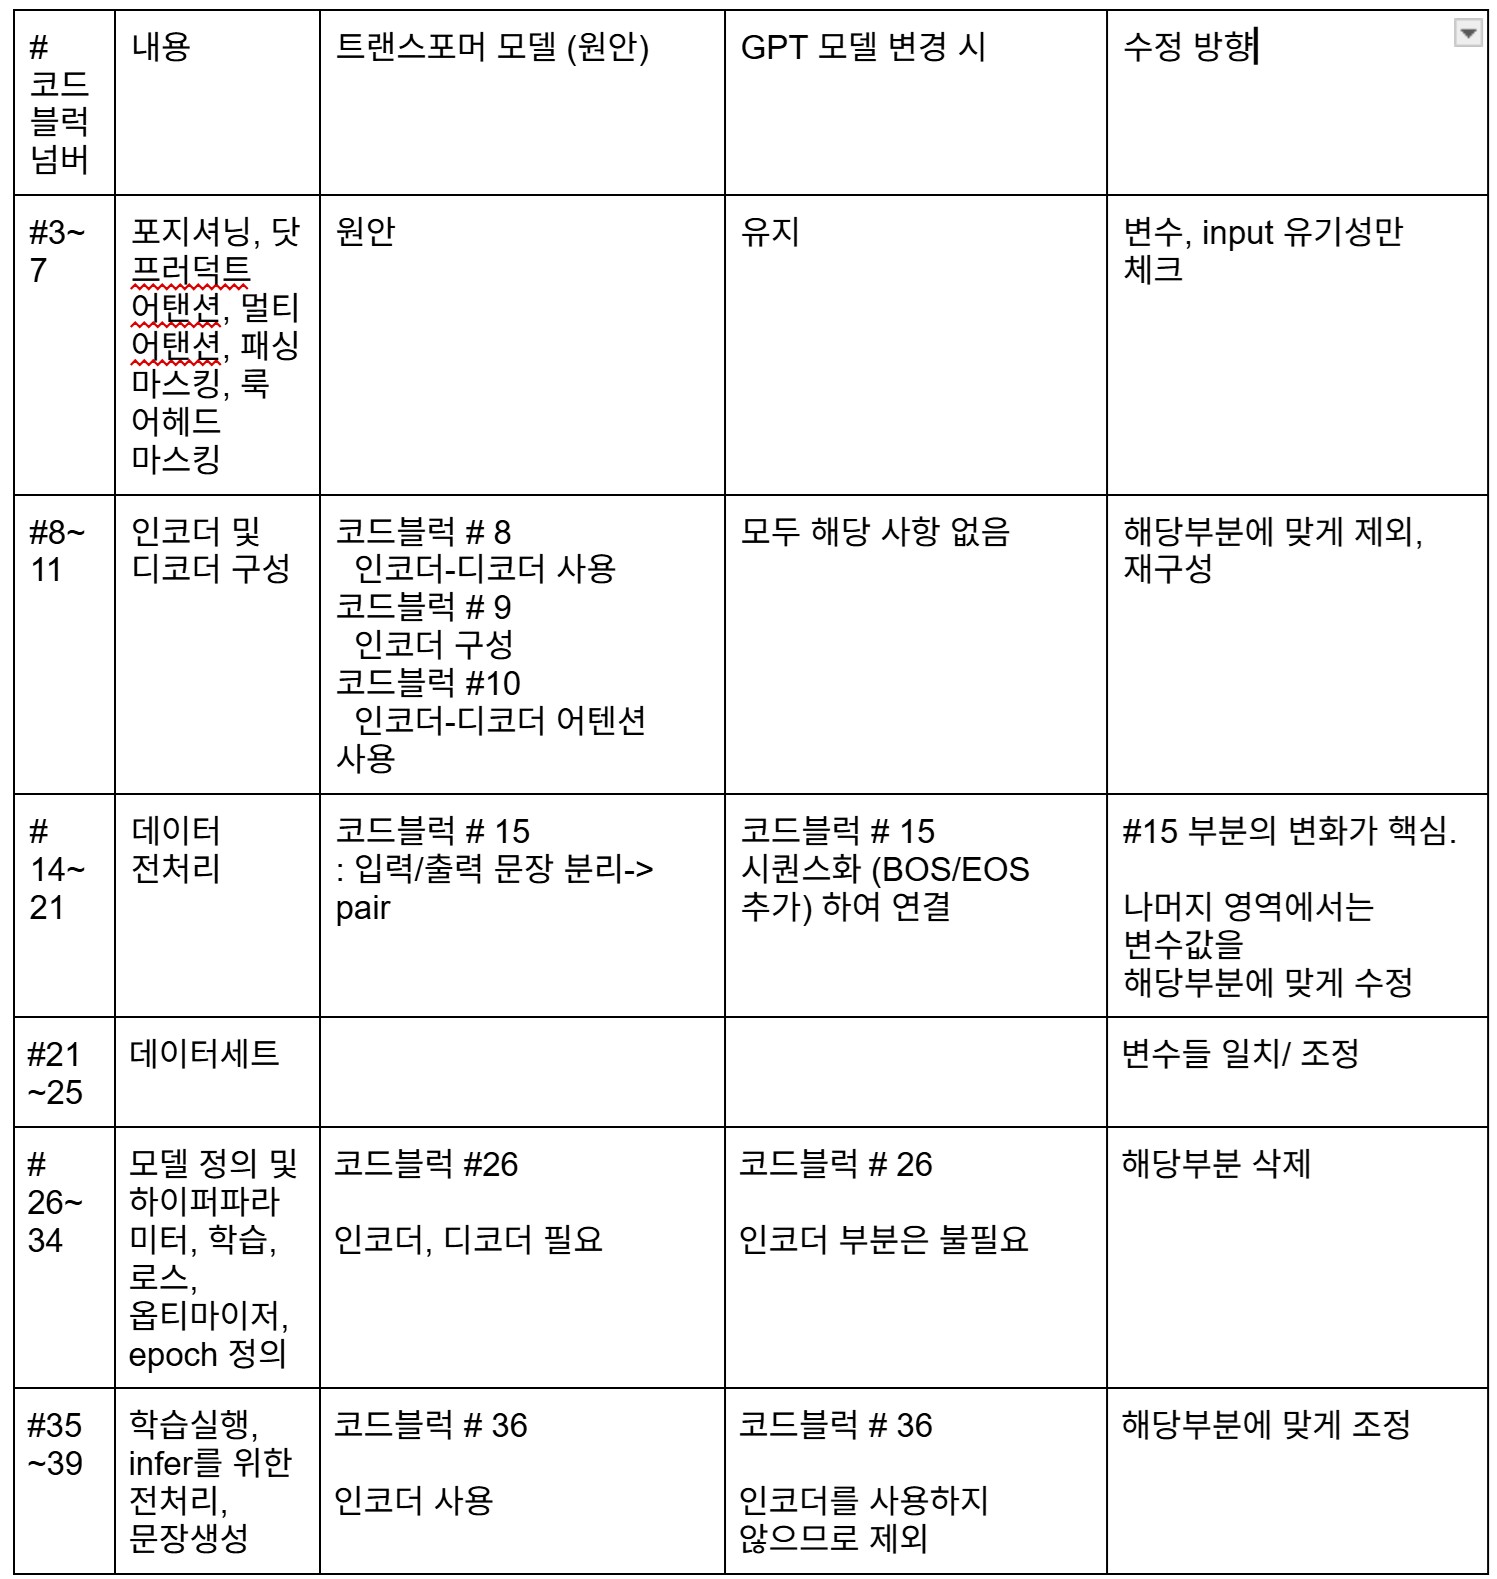

## 퀘스트 2: 전처리 수행
코딩블럭 # 15를 중심으로 진행

# 퀘스트 3: 논문에 기반하여 수정
수행

# 퀘스트 4: GPT 모델 구성
수행. 하단에 분석 및 서머리 결과 참조

# 퀘스트 5: 입력에 따른 출력
수행. 하단 참조

# **라이브러리 및 준비**

In [1]:
# 1. 필요한 라이브러리를 가져옵니다.
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
import torch.optim as optim
import torch.optim.lr_scheduler as lr_scheduler
import sentencepiece as spm

import math
import os
import re
import urllib.request
import zipfile
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# 2. sentence piece를 설치합니다
!pip install sentencepiece

# **트렌스포머의 포지셔닝, 프러덕트 어텐션, 멀티 어텐션, 패딩 마스킹, 록헤드 마스킹 정의**

In [152]:
# 3.포지셔널 행렬을 구현합니다.
class PositionalEncoding(nn.Module):
    def __init__(self, position, d_model):
        super(PositionalEncoding, self).__init__()
        self.d_model = d_model
        self.position = position

        self.pos_encoding = self._build_pos_encoding(position, d_model)

    def _get_angles(self, position, i, d_model):
        return 1.0 / (10000.0 ** ((2.0 * (i // 2)) / d_model)) * position

    def _build_pos_encoding(self, position, d_model):
        pos = torch.arange(position, dtype=torch.float32).unsqueeze(1)
        i = torch.arange(d_model, dtype=torch.float32).unsqueeze(0)

        angle_rads = self._get_angles(pos, i, d_model)
        sines = torch.sin(angle_rads[:, 0::2])
        cosines = torch.cos(angle_rads[:, 1::2])

        pos_encoding = torch.zeros(position, d_model)
        pos_encoding[:, 0::2] = sines
        pos_encoding[:, 1::2] = cosines

        pos_encoding = pos_encoding.unsqueeze(0)  # shape: [1, position, d_model]
        return pos_encoding

    def forward(self, x):
        return x + self.pos_encoding[:, :x.size(1), :].to(x.device)

In [153]:
# 4. 스케일드 닷 프러덕트 어텐션 합수를 구현함
def scaled_dot_product_attention(query, key, value, mask=None):

    # 1) Q와 K의 내적을 통해 score(유사도) 계산
    # key.transpose(-1, -2): (batch_size, heads, depth, seq_len)
    # matmul 결과 shape: (batch_size, heads, seq_len, seq_len)
    matmul_qk = torch.matmul(query, key.transpose(-1, -2))

    # 2) depth에 따라 정규화
    depth = key.size(-1)  # depth = d_model / heads
    logits = matmul_qk / math.sqrt(depth)

    # 3) 마스크가 주어졌다면 -1e9(아주 작은 값)를 더해 소프트맥스에서 제외시키도록 함
    if mask is not None:
        # 텐서플로우: logits += (mask * -1e9)
        # 파이토치 동일 적용
        logits = logits + (mask * -1e9)

    # 4) 소프트맥스 계산해 attention weights 생성
    attention_weights = F.softmax(logits, dim=-1)

    # 5) attention weights와 value의 내적
    output = torch.matmul(attention_weights, value)

    return output, attention_weights

In [154]:
# 5. 멀티 어텐션 함수를 정의
class MultiHeadAttention(nn.Module):
    def __init__(self, d_model, num_heads, name="multi_head_attention"):
        super(MultiHeadAttention, self).__init__()
        self.num_heads = num_heads
        self.d_model = d_model

        # d_model은 num_heads로 나누어 떨어져야 함.
        assert d_model % num_heads == 0

        self.depth = d_model // num_heads

        # 파이토치에서 Dense는 nn.Linear로 대응
        self.query_dense = nn.Linear(d_model, d_model)
        self.key_dense = nn.Linear(d_model, d_model)
        self.value_dense = nn.Linear(d_model, d_model)

        self.out_dense = nn.Linear(d_model, d_model)

    def split_heads(self, x, batch_size):
        """
        x: (batch_size, seq_len, d_model)
        => (batch_size, num_heads, seq_len, depth) 형태로 변환
        """
        x = x.view(batch_size, -1, self.num_heads, self.depth)
        x = x.permute(0, 2, 1, 3)  # (batch_size, num_heads, seq_len, depth)
        return x

    def forward(self, query, key, value, mask=None):
        """
        query, key, value: (batch_size, seq_len, d_model)
        mask: (batch_size, 1, seq_len, seq_len) 등으로 broadcast 가능하도록 구성
        """
        batch_size = query.size(0)

        # Q, K, V에 각각 Linear 적용
        query = self.query_dense(query)
        key = self.key_dense(key)
        value = self.value_dense(value)

        # Head 분할
        query = self.split_heads(query, batch_size)
        key = self.split_heads(key, batch_size)
        value = self.split_heads(value, batch_size)

        # 스케일드 닷 프로덕트 어텐션
        scaled_attention, _ = scaled_dot_product_attention(query, key, value, mask)

        # (batch_size, num_heads, seq_len, depth) -> (batch_size, seq_len, num_heads, depth)
        scaled_attention = scaled_attention.permute(0, 2, 1, 3).contiguous()

        # 다시 (batch_size, seq_len, d_model)로 합치기
        concat_attention = scaled_attention.view(batch_size, -1, self.d_model)

        # 최종 Dense
        output = self.out_dense(concat_attention)
        return output

In [155]:
# 6. 패딩 마스킹을 구현합니다.
def create_padding_mask(x):
    # x == 0 위치를 찾아 float형 1로 변환
    mask = (x == 0).float()
    # (batch_size, seq_len) -> (batch_size, 1, 1, seq_len)
    mask = mask.unsqueeze(1).unsqueeze(2)
    return mask

In [156]:
# 7. 록 어헤드 마스킹 함수를 구현합니다.
def create_look_ahead_mask(x):
    seq_len = x.size(1)

    # (seq_len, seq_len) 크기의 하삼각 행렬(tril) 생성 후 1에서 빼서
    # 상삼각이 1, 하삼각(자기 자신 포함)이 0이 되도록 설정
    # => 미래 토큰(자신 인덱스보다 큰 위치) 마스킹
    look_ahead_mask = 1 - torch.tril(torch.ones((seq_len, seq_len)))

    # 패딩 마스크 생성 (shape: (batch_size, 1, 1, seq_len))
    padding_mask = create_padding_mask(x)

    # look_ahead_mask: (seq_len, seq_len) -> (1, seq_len, seq_len)
    look_ahead_mask = look_ahead_mask.unsqueeze(0)
    # -> (1, seq_len, seq_len) -> (1, 1, seq_len, seq_len)
    look_ahead_mask = look_ahead_mask.unsqueeze(1)
    look_ahead_mask = look_ahead_mask.to(x.device)

    # look-ahead 마스크와 패딩 마스크를 합성 (둘 중 하나라도 1이면 마스킹)
    # 최종 shape은 브로드캐스팅으로 (batch_size, 1, seq_len, seq_len)
    combined_mask = torch.max(look_ahead_mask, padding_mask)
    return combined_mask

# **인코더 구성**

In [ ]:
# 8. 인코더 층을 구현하는 함수입니다 - GPT모델에서 불필요로 제외
# class EncoderLayer(nn.Module):
#   def __init__(self, d_model, num_heads, ff_dim, dropout=0.1):
#        super(EncoderLayer, self).__init__()
#        self.mha = MultiHeadAttention(d_model, num_heads)  # 이전에 구현한 MHA
#        self.dropout1 = nn.Dropout(dropout)
#        self.norm1 = nn.LayerNorm(d_model, eps=1e-6)

        # 피드포워드 부분 (Dense -> ReLU -> Dense)
 #       self.ffn = nn.Sequential(
 #           nn.Linear(d_model, ff_dim),
 #           nn.ReLU(),
 #           nn.Linear(ff_dim, d_model)
 #       )
 #       self.dropout2 = nn.Dropout(dropout)
 #       self.norm2 = nn.LayerNorm(d_model, eps=1e-6)

 #   def forward(self, x, mask=None):
 #       # (1) 멀티 헤드 어텐션 (셀프 어텐션)
 #       attn_output = self.mha(x, x, x, mask)  # (batch_size, seq_len, d_model)
 #       attn_output = self.dropout1(attn_output)
 #       out1 = self.norm1(x + attn_output)     # 잔차 연결 + LayerNorm

 #       # (2) 피드포워드 신경망
 #       ffn_output = self.ffn(out1)            # (batch_size, seq_len, d_model)
 #       ffn_output = self.dropout2(ffn_output)
 #       out2 = self.norm2(out1 + ffn_output)   # 잔차 연결 + LayerNorm

 #       return out2


In [ ]:
# 9. 인코더 층을 쌓아 인코더를 만듭니다. - GPT모델에서 불필요로 제외
# class Encoder(nn.Module):
#    def __init__(self,
#                 vocab_size,
#                 num_layers,
#                 ff_dim,
#                 d_model,
#                 num_heads,
#                 dropout=0.1):
#        super(Encoder, self).__init__()
#        self.d_model = d_model

        # (1) 임베딩 레이어
#        self.embedding = nn.Embedding(vocab_size, d_model)

        # (2) 포지셔널 인코딩
#        self.pos_encoding = PositionalEncoding(position=vocab_size, d_model=d_model)

#        self.dropout = nn.Dropout(dropout)

        # (3) EncoderLayer 쌓기
#        self.enc_layers = nn.ModuleList([
#            EncoderLayer(d_model, num_heads, ff_dim, dropout)
#            for _ in range(num_layers)
#        ])

#    def forward(self, x, mask=None):
        # (1) 임베딩 & sqrt(d_model)로 스케일링
#        x = self.embedding(x) * math.sqrt(self.d_model)

        # (2) 포지셔널 인코딩 적용 + 드롭아웃
#        x = self.pos_encoding(x)  # shape: (batch_size, seq_len, d_model)
#        x = self.dropout(x)

        # (3) num_layers만큼 쌓아올린 EncoderLayer 통과
#        for layer in self.enc_layers:
#            x = layer(x, mask)

#        return x

# **디코더 구성**

In [157]:
# 10, 디코더 layer를 구현합니다 -GPT에 맞게 수정
class DecoderLayer(nn.Module):
    def __init__(self, d_model, num_heads, ff_dim, dropout=0.1):
        super(DecoderLayer, self).__init__()

        # 첫 번째 서브 레이어 (디코더 내부 셀프 어텐션)
        self.self_mha = MultiHeadAttention(d_model, num_heads)
        self.norm1 = nn.LayerNorm(d_model, eps=1e-6)

        # 두 번째 서브 레이어 (인코더-디코더 어텐션) - 불필요
       # self.encdec_mha = MultiHeadAttention(d_model, num_heads)
       # self.norm2 = nn.LayerNorm(d_model, eps=1e-6)

        # 세 번째 서브 레이어 (피드포워드 network)
        self.ffn = nn.Sequential(
            nn.Linear(d_model, ff_dim),  # Dense(units=ff_dim)
            nn.ReLU(),                   # activation='relu'
            nn.Linear(ff_dim, d_model)   # Dense(units=d_model)
        )
        self.norm3 = nn.LayerNorm(d_model, eps=1e-6)

        # 드롭아웃
        self.dropout1 = nn.Dropout(dropout)
       # self.dropout2 = nn.Dropout(dropout) # 불필요
        self.dropout3 = nn.Dropout(dropout)

    def forward(self, x, enc_outputs=None, look_ahead_mask=None, padding_mask=None): # enc_outputs와 padding_mask를 기본값 None으로 설정
        # 1) 셀프 어텐션 (디코더 내부)
        self_attn_out = self.self_mha(x, x, x, mask=look_ahead_mask)
        self_attn_out = self.dropout1(self_attn_out)
        out1 = self.norm1(x + self_attn_out)  # 잔차 연결 + LayerNorm

        # 2) 인코더-디코더 어텐션 - 불필요
       # encdec_attn_out = self.encdec_mha(out1, enc_outputs, enc_outputs, mask=padding_mask)
       # encdec_attn_out = self.dropout2(encdec_attn_out)
       # out2 = self.norm2(out1 + encdec_attn_out)  # 잔차 연결 + LayerNorm

        # 3) 피드포워드 (Dense -> ReLU -> Dense)
        # out2 대신 out1을 사용합니다.
        ffn_out = self.ffn(out1)
        ffn_out = self.dropout3(ffn_out)
        out3 = self.norm3(out1 + ffn_out)  # 잔차 연결 + LayerNorm

        return out3

In [158]:
# 11. 디코더 layer를 쌓아서 디코더를 만듭니다.-GPT에 맞게 수정
class Decoder(nn.Module):
    def __init__(self,
                 vocab_size,
                 num_layers,
                 ff_dim,
                 d_model,
                 num_heads,
                 dropout=0.1):
        super(Decoder, self).__init__()
        self.d_model = d_model

        # (1) 임베딩 레이어
        self.embedding = nn.Embedding(vocab_size, d_model)

        # (2) 포지셔널 인코딩
        # 실제 학습 시에는 최대 시퀀스 길이에 맞추어 쓰기도 함
        self.pos_encoding = PositionalEncoding(position=vocab_size, d_model=d_model)

        self.dropout = nn.Dropout(dropout)

        # (3) DecoderLayer 쌓기
        self.dec_layers = nn.ModuleList([
            DecoderLayer(d_model, num_heads, ff_dim, dropout)
            for _ in range(num_layers)
        ])

    def forward(self, x, look_ahead_mask=None, padding_mask=None): # Removed enc_outputs
        # (1) 임베딩 + sqrt(d_model)로 스케일링
        x = self.embedding(x) * math.sqrt(self.d_model)

        # (2) 포지셔널 인코딩 + 드롭아웃
        x = self.pos_encoding(x)    # (batch_size, tgt_seq_len, d_model)
        x = self.dropout(x)

        # (3) num_layers만큼 쌓인 DecoderLayer 통과
        for layer in self.dec_layers:
            x = layer(x, look_ahead_mask=look_ahead_mask, padding_mask=padding_mask) # Updated layer call

        return x

# **데이터 가져오기 및 전처리**

In [10]:
# 12.  챗봇 데이터를 가져옵니다.
! mkdir -p ~/work/transformer_chatbot/data/ && cd ~/work/transformer_chatbot/data/
! wget https://github.com/songys/Chatbot_data/raw/master/ChatbotData.csv

--2025-11-05 06:51:17--  https://github.com/songys/Chatbot_data/raw/master/ChatbotData.csv
Resolving github.com (github.com)... 140.82.116.3
Connecting to github.com (github.com)|140.82.116.3|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/songys/Chatbot_data/master/ChatbotData.csv [following]
--2025-11-05 06:51:17--  https://raw.githubusercontent.com/songys/Chatbot_data/master/ChatbotData.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.109.133, 185.199.111.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.109.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 889842 (869K) [text/plain]
Saving to: ‘ChatbotData.csv’

ChatbotData.csv     100%[===================>] 868.99K  --.-KB/s    in 0.03s   

2025-11-05 06:51:17 (24.4 MB/s) - ‘ChatbotData.csv’ saved [889842/889842]



In [159]:
# 13. 데이터 형태 체크
import pandas as pd

path_to_dataset = "/content/ChatbotData.csv"

df = pd.read_csv("/content/ChatbotData.csv")

print("컬럼:", df.columns.tolist())
print("\n앞 데이터 5개:")
print(df.head())
print("\n데이터 정보:")
print(df.info())
print(df.shape)

컬럼: ['Q', 'A', 'label']

앞 데이터 5개:
                 Q            A  label
0           12시 땡!   하루가 또 가네요.      0
1      1지망 학교 떨어졌어    위로해 드립니다.      0
2     3박4일 놀러가고 싶다  여행은 언제나 좋죠.      0
3  3박4일 정도 놀러가고 싶다  여행은 언제나 좋죠.      0
4          PPL 심하네   눈살이 찌푸려지죠.      0

데이터 정보:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11823 entries, 0 to 11822
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Q       11823 non-null  object
 1   A       11823 non-null  object
 2   label   11823 non-null  int64 
dtypes: int64(1), object(2)
memory usage: 277.2+ KB
None
(11823, 3)


In [160]:
# 14. 전처리 함수 정의
def preprocess_sentence(sentence):
  # 입력받은 sentence를 소문자로 변경하고 양쪽 공백을 제거
  # 한국어는 소문자 변환이 크게 의미 없을 수 있으나, 일관성을 위해 유지
  sentence = sentence.lower().strip()

  # 단어와 구두점(punctuation) 사이의 거리를 만듭니다.
  # ? !와 한글, 영어, 숫자 외의 문자는 공백으로 치환. .,가 너무 많이 나옴
  # 한글 자음, 모음 분리 현상은 SentencePiece가 처리하므로 여기서는 제거 안함
  sentence = re.sub(r"([?!])", r" \1 ", sentence)
  sentence = re.sub(r'[" "]+', " ", sentence)

  # 한글, 영어, 숫자, 그리고 "?", "!" 만 남기고 모두 제거
  sentence = re.sub(r"[^가-힣a-zA-Z0-9?!]+", " ", sentence)
  sentence = sentence.strip()
  return sentence
print("슝=3")

슝=3


In [161]:
# 15. 데이터를 가져와서 미싱 혹은 중복 제거, 전처리 후 텍스트 지정- gpt에 필요한 연결 방식으로 수정
def read_cb_data(path_to_dataset):
    # Load the data from the CSV file.
    df = pd.read_csv(path_to_dataset)[['Q', 'A']]
    df = df.dropna().drop_duplicates()

    texts = [] # gpt 모델에 맞는 연결방식 적용
    for _, row in df.iterrows():
        q = preprocess_sentence(row['Q'])
        a = preprocess_sentence(row['A'])
        if q and a:
            # Q와 A를 특수 토큰으로 구분하여 연결
            text = f"<Q> {q} <A> {a}"
            texts.append(text)

    return texts

In [162]:
# 16. 데이터셋 확인 - gpt모델에 맞추어 변수 및 결과 체크 수정
texts = read_cb_data(path_to_dataset)
print(f'데이터셋 크기: {len(texts)}')
print('데이터셋 예시:')
for i in range(5):
    print(texts[i])

데이터셋 크기: 11750
데이터셋 예시:
<Q> 12시 땡 ! <A> 하루가 또 가네요
<Q> 1지망 학교 떨어졌어 <A> 위로해 드립니다
<Q> 3박4일 놀러가고 싶다 <A> 여행은 언제나 좋죠
<Q> 3박4일 정도 놀러가고 싶다 <A> 여행은 언제나 좋죠
<Q> ppl 심하네 <A> 눈살이 찌푸려지죠


In [163]:
# 17. 코푸스 파일 지정 - gpt 모델에 맞추어 변수 수정
corpus_file = "clean_corpus.txt"
with open(corpus_file, 'w', encoding='utf-8') as f:
    for text in texts:
        f.write(text + "\n")

In [164]:
# 18. 센텐스피스
spm.SentencePieceTrainer.Train(
    input=corpus_file,
    model_prefix="spm_cb",
    vocab_size=2000,  # Increase vocabulary size now that data is correctly preprocessed
    character_coverage=1.0,
    model_type="bpe",
    max_sentence_length=40, #40 설정
    bos_id=1,  # <s> (Beginning of Sentence) 설정
    eos_id=2,  # </s> (End of Sentence) 설정
    pad_id=0,  # Padding ID 설정
    unk_id=3   # Unknown Token ID 설정
)

sp = spm.SentencePieceProcessor()
sp.Load("spm_cb.model")

print(f"SentencePiece vocabulary size: {sp.GetPieceSize()}")

SentencePiece vocabulary size: 2000


In [165]:
# 19. 센텐스피스
sp = spm.SentencePieceProcessor()
sp.Load("spm_cb.model")

True

In [166]:
# 20. 예제 문장을 통한 체크
sentence = "한국말을 테스트 하는 중이야!"

sentence = preprocess_sentence(sentence)
print("전처리 후의 문장:", sentence)

# 1. 토크나이징 (subword 단위로 분할)
tokens = sp.encode(sentence, out_type=str)
print("Tokenized:", tokens)

# 2. 인코딩 (서브워드를 정수 ID로 변환)
encoded = sp.encode(sentence, out_type=int)
print("Encoded:", encoded)

# 3. 디코딩 (정수 ID → 원본 문장 복원)
decoded = sp.decode(encoded)
print("Decoded:", decoded)


전처리 후의 문장: 한국말을 테스트 하는 중이야 !
Tokenized: ['▁한', '국', '말', '을', '▁', '테', '스', '트', '▁하', '는', '▁중', '이야', '▁!']
Encoded: [46, 3, 1649, 1757, 1597, 1983, 3, 1985, 67, 1727, 134, 144, 7]
Decoded: 한 ⁇ 말을 테 ⁇ 트 하는 중이야 !


# **데이터셋 설정**

In [167]:
# 21. 챗봇 데이터셋 정의 함수 - gpt 모델에 맞추어 수정, 변수, 패딩 방식 등
class cbDataset(Dataset):
    def __init__(self, texts, sp, max_length=40):
        super().__init__()
        self.sp = sp
        self.max_length = max_length
        self.data = []

        for text in texts: #변수명 변화
            # Split the combined text back into Q and A
            parts = text.split("<A>")
            if len(parts) != 2:
                # Skip malformed entries
                continue

            q_text = parts[0].replace("<Q>", "").strip()
            a_text = parts[1].strip()

            # 1) 토크나이즈
            q_ids = sp.EncodeAsIds(q_text)
            a_ids = sp.EncodeAsIds(a_text)

            # 2) [CLS]/[SEP] 같은 별도 스페셜 토큰을 쓸 수도 있으나,
            #    여기서는 SentencePiece 기본 <s>, </s> 등 혹은 사용자 정의 토큰 활용 가능
            #    간단히 <s>=sp.bos_id(), </s>=sp.eos_id()로 가정해본다면:
            #    sp.SetEncodeExtraOptions("bos:eos") 등으로 설정하는 방법도 있음.
            # 여기서는 수동으로 bos/eos id를 붙인다고 가정
            bos_id = sp.bos_id() if sp.bos_id() >= 0 else 1  # 혹은 임의값
            eos_id = sp.eos_id() if sp.eos_id() >= 0 else 2

            q_tokens = [bos_id] + q_ids + [eos_id]
            a_tokens = [bos_id] + a_ids + [eos_id]

            # 3) 길이 제한
            if len(q_tokens) > max_length or len(a_tokens) > max_length:
                continue

            # 4) 고정 길이 패딩-패딩 방식 변화
            q_tokens += [self.sp.pad_id()]*(max_length - len(q_tokens))  # 0 -> <pad> 가정
            a_tokens += [self.sp.pad_id()]*(max_length - len(a_tokens))

            # 5) 디코더 입력(dec_input): a_tokens[:-1], 타겟(outputs): a_tokens[1:]
            #    (teacher forcing용)
            dec_input = a_tokens[:-1]
            target = a_tokens[1:]

            self.data.append({
                "enc_input": q_tokens,
                "dec_input": dec_input,
                "target": target
            })

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        sample = self.data[idx]
        enc_input = torch.tensor(sample["enc_input"], dtype=torch.long)
        dec_input = torch.tensor(sample["dec_input"], dtype=torch.long)
        target = torch.tensor(sample["target"], dtype=torch.long)
        return enc_input, dec_input, target

In [168]:
# 22. 데이테세트 정의 - gpt 모델에 맞게 변수 수정
dataset = cbDataset(texts, sp, max_length=40)

In [169]:
# 23. 텐서 결과 체크
for encoder_input, decoder_input, decoder_label  in dataset:
    print("텐서 크기 :",encoder_input.size())
    print(encoder_input)
    print(sp.decode(encoder_input.tolist()))
    print(decoder_input)
    print(sp.decode(decoder_input.tolist()))
    print(decoder_label)
    print(sp.decode(decoder_label.tolist()))
    break

텐서 크기 : torch.Size([40])
tensor([   1, 1597,    3, 1869, 1650, 1597,    3,    7,    2,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0])
 ⁇ 2시  ⁇  !
tensor([   1,   67,    3, 1611,  184,   42,   12,    2,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0])
하 ⁇ 가 또 가네요
tensor([  67,    3, 1611,  184,   42,   12,    2,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0])
하 ⁇ 가 또 가네요


In [170]:
# 24. 데이터로더 정의
dataloader = DataLoader(dataset,batch_size=32,shuffle=True)

In [171]:
# 25. 데이터로더 체크. decoder에 들어갈 데이터는 하나가 줄어들게 된다. 다음과 같은 데이터 형태가 맞다.
for encoder_input, decoder_input, decoder_label in dataloader:
    print(encoder_input.size())
    print(decoder_input.size())
    print(decoder_label.size())
    break

torch.Size([32, 40])
torch.Size([32, 39])
torch.Size([32, 39])


# **모델 정의**

In [172]:
# 26. 모델 정의 - gpt 모델에 맞게 변수 수정
class Transformer(nn.Module):
    def __init__(self,
                 vocab_size,
                 num_layers,      # 인코더/디코더 층 수 (GPT는 디코더 층만 사용)
                 units,           # feed-forward 네트워크의 중간 차원(ff_dim)
                 d_model,         # 임베딩 및 내부 표현 차원
                 num_heads,       # 멀티헤드 어텐션의 헤드 수
                 dropout=0.1):
        super(Transformer, self).__init__()

        # 인코더 - GPT는 인코더가 없습니다.
    #    self.encoder = Encoder(
    #        vocab_size=vocab_size,
    #        num_layers=num_layers,
    #        ff_dim=units,
    #        d_model=d_model,
    #        num_heads=num_heads,
    #        dropout=dropout
    #    )

        # 디코더
        self.decoder = Decoder(
            vocab_size=vocab_size,
            num_layers=num_layers,
            ff_dim=units,
            d_model=d_model,
            num_heads=num_heads,
            dropout=dropout
        )

        # 최종 출력층: (d_model) -> (vocab_size)
        self.final_linear = nn.Linear(d_model, vocab_size)

        # 참고: 텐서플로우 코드의 `name="transformer"`는 파이토치에선 보통 사용 안 함

    def forward(self, inputs, dec_inputs):
        # GPT는 인코더가 없으므로 인코더 관련 마스크 생성 및 호출은 불필요
        # 1) 인코더 패딩 마스크 생성 - 불필요
        # enc_padding_mask = create_padding_mask(inputs)

        # 2) 디코더 look-ahead + 패딩 마스크 (self-attention mask)
        # dec_inputs에 대한 마스크만 필요
        look_ahead_mask = create_look_ahead_mask(dec_inputs)

        # 3) 디코더에서 인코더 출력 쪽을 마스킹할 때 쓸 패딩 마스크 - 불필요
        # dec_padding_mask = create_padding_mask(inputs)

        # 4) 인코더 수행 - 불필요
     #   enc_outputs = self.encoder(
     #       x=inputs,
     #       mask=enc_padding_mask
     #   )

        # 5) 디코더 수행
        # GPT는 인코더 출력을 받지 않습니다. dec_inputs와 look_ahead_mask만 전달
        dec_outputs = self.decoder(
            x=dec_inputs,           # (batch_size, tgt_seq_len)
            # enc_outputs는 GPT에 없으므로 전달하지 않습니다.
            # enc_outputs=None,
            look_ahead_mask=look_ahead_mask,
            # padding_mask는 GPT에 없으므로 전달하지 않습니다.
            # padding_mask=None
        )  # shape: (batch_size, tgt_seq_len, d_model)

        # 6) 최종 Dense (vocab_size)
        logits = self.final_linear(dec_outputs)  # (batch_size, tgt_seq_len, vocab_size)
        return logits

In [173]:
# 27. 하이퍼파라미터 설정
NUM_LAYERS = 3     # 인코더/디코더 층 수
D_MODEL = 256      # 임베딩 및 내부 표현 차원
NUM_HEADS = 8      # 멀티헤드 어텐션에서의 헤드 수
UNITS = 512        # 피드포워드 신경망의 은닉 차원
DROPOUT = 0.1      # 드롭아웃 비율
VOCAB_SIZE = 2000 # Update vocab size to match SentencePiece

# 모델 생성
model = Transformer(
    vocab_size=VOCAB_SIZE,
    num_layers=NUM_LAYERS,
    units=UNITS,
    d_model=D_MODEL,
    num_heads=NUM_HEADS,
    dropout=DROPOUT
)

print(model)

Transformer(
  (decoder): Decoder(
    (embedding): Embedding(2000, 256)
    (pos_encoding): PositionalEncoding()
    (dropout): Dropout(p=0.1, inplace=False)
    (dec_layers): ModuleList(
      (0-2): 3 x DecoderLayer(
        (self_mha): MultiHeadAttention(
          (query_dense): Linear(in_features=256, out_features=256, bias=True)
          (key_dense): Linear(in_features=256, out_features=256, bias=True)
          (value_dense): Linear(in_features=256, out_features=256, bias=True)
          (out_dense): Linear(in_features=256, out_features=256, bias=True)
        )
        (norm1): LayerNorm((256,), eps=1e-06, elementwise_affine=True)
        (ffn): Sequential(
          (0): Linear(in_features=256, out_features=512, bias=True)
          (1): ReLU()
          (2): Linear(in_features=512, out_features=256, bias=True)
        )
        (norm3): LayerNorm((256,), eps=1e-06, elementwise_affine=True)
        (dropout1): Dropout(p=0.1, inplace=False)
        (dropout3): Dropout(p=0.1, 

In [174]:
# 28. 로스 함수 정의
loss_function = nn.CrossEntropyLoss(ignore_index=sp.pad_id())

In [175]:
# 29. 학습 함수 정의
def get_lr_lambda(d_model, warmup_steps=4000):
    d_model = float(d_model)
    def lr_lambda(step):
        # step은 0부터 시작하므로 +1로 보정
        step = step + 1
        return (d_model ** -0.5) * min(step ** -0.5, step * (warmup_steps ** -1.5))
    return lr_lambda

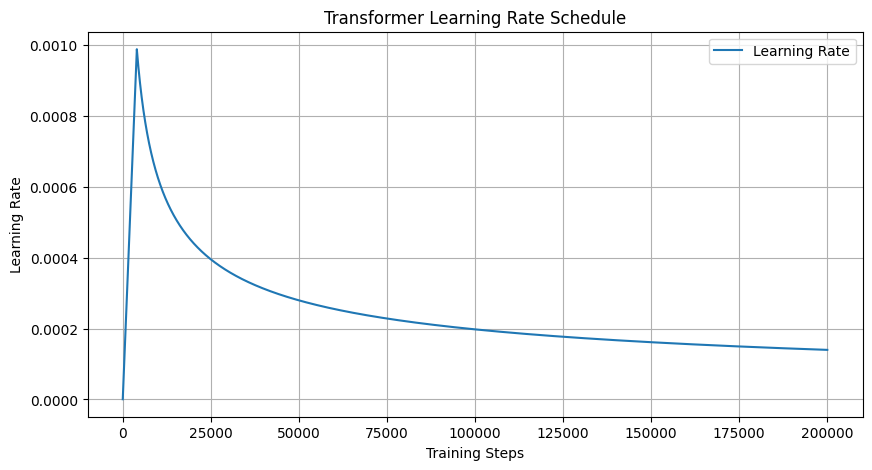

In [176]:
# 30. 학습 하이퍼파라미터 설정
d_model = 256
warmup_steps = 4000
total_steps = 200000  # 총 학습 스텝

# 학습률 스케줄 시각화
steps = np.arange(1, total_steps + 1)
learning_rates = [get_lr_lambda(d_model, warmup_steps)(step) for step in steps]

# 그래프 출력
plt.figure(figsize=(10, 5))
plt.plot(steps, learning_rates, label="Learning Rate")
plt.xlabel("Training Steps")
plt.ylabel("Learning Rate")
plt.title("Transformer Learning Rate Schedule")
plt.legend()
plt.grid(True)
plt.show()


In [177]:
# 31. Optimizer 및 scheduler 정의
optimizer = optim.Adam(model.parameters(), betas=(0.9, 0.98), eps=1e-9)

# Scheduler 정의
scheduler = lr_scheduler.LambdaLR(optimizer, lr_lambda=get_lr_lambda(D_MODEL, warmup_steps=4000))

def accuracy_function(y_pred, y_true, pad_id=0):
    """
    y_pred: (batch_size, seq_len, vocab_size)
    y_true: (batch_size, seq_len)
    """
    preds = y_pred.argmax(dim=-1)  # (batch_size, seq_len)
    mask = (y_true != pad_id)
    correct = (preds == y_true) & mask
    acc = correct.float().sum() / mask.float().sum()
    return acc

In [178]:
# 32. Define the device to use for training
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


In [179]:
# 33. 트레인 함수 정의
def train_step(model, batch, optimizer, loss_function, device):
    model.train()
    enc_input, dec_input, target = [x.to(device) for x in batch]


    optimizer.zero_grad()

    # 모델 포워드 패스
    logits = model(enc_input, dec_input)  # (batch_size, seq_len, vocab_size)

    # Loss 계산 (패딩 토큰 무시)
    loss = loss_function(logits.permute(0, 2, 1), target)  # (batch_size, vocab_size, seq_len) 필요

    # Backpropagation
    loss.backward()
    optimizer.step()

    return loss.item(), accuracy_function(logits, target, pad_id=sp.pad_id())

In [181]:
# 34. epoch 등 정의 - 수정
def train(model, dataloader, optimizer, loss_function, scheduler, num_epochs, device):
    model.to(device)

    # Lists to store metrics per epoch
    train_losses = []
    train_accuracies = []

    for epoch in range(num_epochs):
        total_loss, total_acc = 0, 0
        num_batches = 0
        for step, batch in enumerate(dataloader):
            loss, acc = train_step(model, batch, optimizer, loss_function, device)
            total_loss += loss
            total_acc += acc
            num_batches += 1

            # 일정 스텝마다 로그 출력 - 출력 다하니 넘 느려지네
           # if step % 100 == 0:
           #     print(f"[Epoch {epoch+1}, Step {step}] Loss: {loss:.4f}, Acc: {acc:.4f}")

            # 학습률 스케줄러 업데이트
            scheduler.step()

        # Calculate average loss and accuracy for the epoch
        avg_loss = total_loss / num_batches
        avg_acc = total_acc / num_batches

        # Store epoch metrics
        train_losses.append(avg_loss)
        train_accuracies.append(avg_acc)

        print(f"Epoch {epoch+1} Completed - Avg Loss: {avg_loss:.4f}, Avg Acc: {avg_acc:.4f}")

    # Return the recorded metrics
    return train_losses, train_accuracies

# **학습 실행 및 결과 평가**

In [182]:
# 35. 학습 실행 - 시간 상 중단
%%time

train(
    model=model,
    dataloader=dataloader,
    optimizer=optimizer,
    loss_function=loss_function,
    scheduler=scheduler,
    num_epochs=500,  # 원하는 에폭 수
    device=device
)

Epoch 1 Completed - Avg Loss: 7.7051, Avg Acc: 0.0024
Epoch 2 Completed - Avg Loss: 7.6788, Avg Acc: 0.0058
Epoch 3 Completed - Avg Loss: 7.6254, Avg Acc: 0.0186
Epoch 4 Completed - Avg Loss: 7.5468, Avg Acc: 0.0403
Epoch 5 Completed - Avg Loss: 7.4417, Avg Acc: 0.0504
Epoch 6 Completed - Avg Loss: 7.3097, Avg Acc: 0.0627
Epoch 7 Completed - Avg Loss: 7.1570, Avg Acc: 0.0990
Epoch 8 Completed - Avg Loss: 6.9788, Avg Acc: 0.1422
Epoch 9 Completed - Avg Loss: 6.7875, Avg Acc: 0.1711
Epoch 10 Completed - Avg Loss: 6.5881, Avg Acc: 0.1803
Epoch 11 Completed - Avg Loss: 6.3963, Avg Acc: 0.1824
Epoch 12 Completed - Avg Loss: 6.2269, Avg Acc: 0.1819
Epoch 13 Completed - Avg Loss: 6.0972, Avg Acc: 0.1825
Epoch 14 Completed - Avg Loss: 5.9943, Avg Acc: 0.1834
Epoch 15 Completed - Avg Loss: 5.9093, Avg Acc: 0.1855
Epoch 16 Completed - Avg Loss: 5.8355, Avg Acc: 0.1870
Epoch 17 Completed - Avg Loss: 5.7689, Avg Acc: 0.1884
Epoch 18 Completed - Avg Loss: 5.7090, Avg Acc: 0.1895
Epoch 19 Completed 

KeyboardInterrupt: 

In [183]:
# 36.infer를 위한 전처리 - GPT 모델을 위한 수정
def decoder_inference(model, sentence, tokenizer, device='cpu'):
    START_TOKEN = tokenizer.bos_id()
    END_TOKEN = tokenizer.eos_id()
    MAX_LENGTH = 40

    # 전처리
    sentence = preprocess_sentence(sentence)

    # 인코딩
    # 인코더 입력: [START] + 인코딩 + [END] -인코더 없으므로 제외
   # enc_input_ids = [START_TOKEN] + tokenizer.encode(sentence) + [END_TOKEN]
    # 차원 확장: (batch_size=1, seq_len)
   # enc_input = torch.tensor([enc_input_ids], dtype=torch.long, device=device)

    # 디코더 입력(dec_input)을 START_TOKEN만 포함한 상태로 시작
    dec_input = torch.tensor([[START_TOKEN]], dtype=torch.long, device=device)

    model.eval()  # 모델 평가 모드
    with torch.no_grad():
        for i in range(MAX_LENGTH):
            # 모델 forward: (dec_input) -> (batch_size=1, seq_len, vocab_size)
            # GPT 모델은 디코더 입력만 받습니다.
            logits = model(None, dec_input) # Pass None for the first argument (encoder input)

            # 마지막 타임스텝의 예측만 추출: shape (1, 1, vocab_size)
            # logits[:, -1, :] -> (1, vocab_size)
            last_step_logits = logits[:, -1, :]

            # argmax로 가장 높은 확률의 토큰 선택
            predicted_id = torch.argmax(last_step_logits, dim=-1)  # shape: (1,)

            # 종료 토큰이면 중단
            if predicted_id.item() == END_TOKEN:
                break

            # 디코더 입력(dec_input)에 예측 토큰을 이어붙임
            predicted_id = predicted_id.unsqueeze(0)  # shape (1,1)
            dec_input = torch.cat([dec_input, predicted_id], dim=1)

    # 최종 시퀀스: dec_input: (1, seq_len)에서 (seq_len,)로
    output_sequence = dec_input.squeeze(0).tolist()  # e.g. [START_TOKEN, ..., 토큰들...]

    return output_sequence

In [184]:
# 37. 문장 생성
def sentence_generation(model, sentence, tokenizer, device='cpu'):
    # 디코더 인퍼런스 -> 예측된 토큰 시퀀스
    output_seq = decoder_inference(model, sentence, tokenizer, device=device)

    # 토크나이저로 디코딩 (패딩, START/END 토큰 등은 제외하거나 처리)
    # 여기서는 단순히 tokenizer.decode() 직접 호출
    predicted_sentence = tokenizer.decode(
        [token for token in output_seq if token < tokenizer.GetPieceSize()]
    )

    print("입력 :", sentence)
    print("출력 :", predicted_sentence)
    return predicted_sentence

In [185]:
# 38. 결과 테스트 - 현단계에서는 퍼보먼스가 판단이 안된다
sentence = '졸려요'
sentence_generation(model, sentence, sp, device)

입력 : 졸려요
출력 :  ⁇ 이  ⁇ 이  ⁇ 이  ⁇ 이  ⁇ 요


' ⁇ 이  ⁇ 이  ⁇ 이  ⁇ 이  ⁇ 요'

# **모델 및 핏 summary**

1) ACC는 약 30% 도달하였으나, 더 학습하여야 성과를 알 수 있을 듯하다. 현단계에서는 아직 정상적인 답변이 나오고 있지 않다. 분석에 의하면 1) 모델과 데이터가 맞지 않거나, 2) EPOCH수가 너무 적거나, 3) 보캡이 너무 적다

2) 트랜스 포머 대비 성과는 현재 기준으로는 ACC 레벨이 대동소이하다


# **GPT 모델 변환 결과 소회**
상기 결과가 나오는 가설적 이유는 1) 한국어 VOCAB이 1200개로 너무 적다, 2) EPOCH TRANING 122에서 중단, 3) 모델에 비해서 데이터 사이즈가 너무 작다.-> 대응 방안: 보캐 규모를 키우고, 2)에포크 숫자를 늘려보겠다

# **별첨 코드 블럭**

Epoch 1 Completed - Avg Loss: 4.9821, Avg Acc: 0.2074
Epoch 2 Completed - Avg Loss: 4.9605, Avg Acc: 0.2092
Epoch 3 Completed - Avg Loss: 4.9430, Avg Acc: 0.2092
Epoch 4 Completed - Avg Loss: 4.9239, Avg Acc: 0.2112
Epoch 5 Completed - Avg Loss: 4.9063, Avg Acc: 0.2124
Epoch 6 Completed - Avg Loss: 4.8898, Avg Acc: 0.2127
Epoch 7 Completed - Avg Loss: 4.8741, Avg Acc: 0.2140
Epoch 8 Completed - Avg Loss: 4.8566, Avg Acc: 0.2153
Epoch 9 Completed - Avg Loss: 4.8409, Avg Acc: 0.2164
Epoch 10 Completed - Avg Loss: 4.8276, Avg Acc: 0.2181


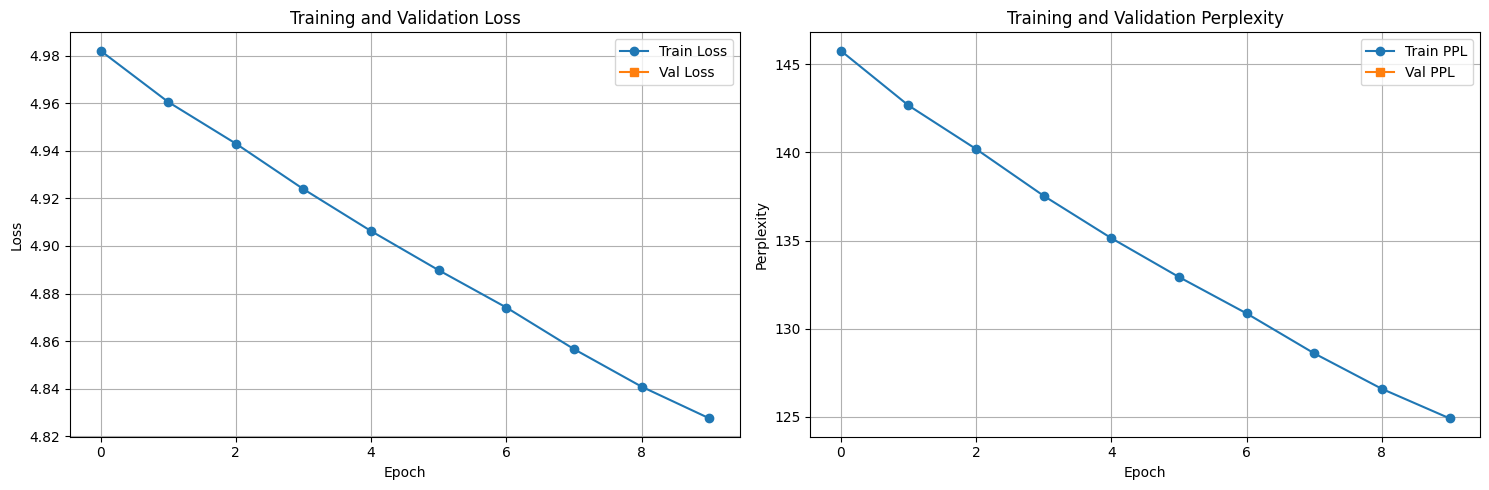

In [119]:
# 39 블럭은 추가적으로 학습 곡선을 평가하기 위하여 추가하였으나 학습 및 val 데이터가 분리되지 않아서 이를 적용해도 큰 의미가 없다가 판단되어 맨 밑에 별첨으로 남김. 다른 평가 방법을 적용해야할 듯
import matplotlib.pyplot as plt

def plot_training_curves(train_losses, val_losses, train_ppls, val_ppls):
    """
    학습 곡선 시각화
    """
    fig, axes = plt.subplots(1, 2, figsize=(15, 5))

    # Loss 곡선
    axes[0].plot(train_losses, label='Train Loss', marker='o')
    axes[0].plot(val_losses, label='Val Loss', marker='s')
    axes[0].set_xlabel('Epoch')
    axes[0].set_ylabel('Loss')
    axes[0].set_title('Training and Validation Loss')
    axes[0].legend()
    axes[0].grid(True)

    # Perplexity 곡선
    axes[1].plot(train_ppls, label='Train PPL', marker='o')
    axes[1].plot(val_ppls, label='Val PPL', marker='s')
    axes[1].set_xlabel('Epoch')
    axes[1].set_ylabel('Perplexity')
    axes[1].set_title('Training and Validation Perplexity')
    axes[1].legend()
    axes[1].grid(True)

    plt.tight_layout()
    plt.savefig('training_curves.png', dpi=300, bbox_inches='tight')
    plt.show()

    # 과적합 확인
    if val_losses and val_losses[-1] > val_losses[-5]:
        print("⚠️ 과적합 경고: Validation loss가 증가하고 있습니다.")

    if val_ppls and train_ppls and val_ppls[-1] > train_ppls[-1] * 1.5:
        print("⚠️ 과적합 경고: Val PPL이 Train PPL보다 50% 이상 높습니다.")

# Initialize empty lists to avoid NameError for now
# train_losses = []
# val_losses = []
# train_ppls = []
# val_ppls = []

# Call the train function to get the metrics
# Assuming you have already run the training cell (104c452c) and want to plot after training
# If not, you would need to run the training cell first

# To plot after training, you would typically call the train function and store the results:
# train_losses, train_accuracies = train(...) # Call the train function

# For now, assuming train_losses and train_accuracies are available from a previous run
# Replace the placeholder with the actual variables if they are in the global scope after training
# If not, you need to rerun the training cell and then this cell.

# Placeholder call - replace with actual variables after running training if needed
# For demonstration, using the values from the last training run output
# In a real scenario, you would get these from the train function return
# Example based on the last output:
# train_losses = [7.2041, 7.1474, 7.0641, 6.9562, 6.8239, 6.6722, 6.5028, 6.3209, 6.1454, 5.9800]
# train_accuracies = [0.0009, 0.0062, 0.0240, 0.0458, 0.0668, 0.0990, 0.1339, 0.1545, 0.1683, 0.1769]

# Call the train function to get the metrics before plotting
train_losses, train_accuracies = train(
    model=model,
    dataloader=dataloader,
    optimizer=optimizer,
    loss_function=loss_function,
    scheduler=scheduler,
    num_epochs=10,  # Use the same number of epochs as the training run
    device=device
)


# Use empty lists for validation metrics and calculate perplexity from loss
val_losses = []
val_ppls = [] # Validation perplexity is not calculated in the current train function

# Calculate training perplexity from training loss
# Perplexity = exp(loss)
train_ppls = [math.exp(loss) for loss in train_losses]


# Call the plotting function
plot_training_curves(train_losses, val_losses, train_ppls, val_ppls)